In [1]:
# diagnostics_counts_poisson_nb_vertical_fixed.py
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import NegativeBinomial
from scipy import stats
from matplotlib.backends.backend_pdf import PdfPages

sns.set(style="whitegrid")
plt.rcParams.update({"font.size": 11})

# Configuració
PATH = r"C:\Users\bfeli\rates_all_metrics_cleaned.csv"
OUTDIR = "diagnostics_counts_output_fixed"
os.makedirs(OUTDIR, exist_ok=True)

DEPENDENTS_COUNTS = ["feminicidis", "denuncies", "ordres"]
PREDICTOR = "votes_per100k_used" 
OFFSET_COL = "population"
CONTROLS = ["atur_annual_mean_pct", "immigracio_per100k"]
TOP_K = 8
DPI = 300

def safe_log(x):
    return np.log(np.maximum(x, 1e-9))

df = pd.read_csv(PATH, encoding="utf-8-sig", low_memory=False)
print("Fitxer llegit:", PATH, "n =", len(df))

# comprovar columnes
needed_cols = [OFFSET_COL, PREDICTOR] + CONTROLS + DEPENDENTS_COUNTS
missing = [c for c in needed_cols if c not in df.columns]
if missing:
    raise SystemExit(f"Falten columnes: {missing}")

results_summary = []

pdf_path = os.path.join(OUTDIR, "diagnostics_counts_models_A4_vertical_fixed.pdf")
with PdfPages(pdf_path) as pdf:
    for dep in DEPENDENTS_COUNTS:
        print("\nProcesant dependent (counts):", dep)
        cols = [dep, OFFSET_COL, PREDICTOR] + CONTROLS
        sub = df[cols].dropna().copy()
        n = len(sub)
        if n < 10:
            print(f"  Pocs casos per {dep} (n={n}) - saltant")
            continue

        # y es comptador
        y = sub[dep].astype(float)
        offset = safe_log(sub[OFFSET_COL].astype(float))
        X = sub[[PREDICTOR] + CONTROLS].astype(float)
        X = sm.add_constant(X, has_constant='add')

        # predictors
        var_zero = X.loc[:, X.columns != 'const'].var() == 0
        if var_zero.any():
            print("  AVÍS: predictors amb var==0:", list(var_zero[var_zero].index))

        # Fit Poisson GLM
        try:
            glm_poisson = sm.GLM(y, X, family=sm.families.Poisson(), offset=offset).fit()
            mu_pois = glm_poisson.predict(X, offset=offset)
        except Exception as e:
            print("  Error ajustant Poisson:", e)
            glm_poisson = None
            mu_pois = np.full(n, np.nan)

        # Fit NegBin: NegativeBinomial, fallback to GLM NegativeBinomial
        mu_nb = np.full(n, np.nan)
        nb_res = None
        try:
            nb_mod = NegativeBinomial(y, X)
            nb_res = nb_mod.fit(disp=False, maxiter=200)
            mu_nb = nb_res.predict(X)
            print("  NB (discrete) ajustat OK")
        except Exception as e1:
            print("  NB discrete failed:", str(e1))
            # fallback a GLM NegativeBinomial
            try:
                glm_nb = sm.GLM(y, X, family=sm.families.NegativeBinomial(), offset=offset).fit()
                mu_nb = glm_nb.predict(X, offset=offset)
                nb_res = glm_nb 
                print("  NB GLM (families.NegativeBinomial) ajustat OK")
            except Exception as e2:
                print("  NB fallback GLM també ha fallat:", str(e2))
                mu_nb = np.full(n, np.nan)
                nb_res = None

        # taxes per plotting
        pop = sub[OFFSET_COL].astype(float)
        rate_obs = (y / pop) * 100000
        rate_pois = (mu_pois / pop) * 100000
        rate_nb = (mu_nb / pop) * 100000

        # diagnostics numèrics
        if glm_poisson is not None:
            p_pois = int(glm_poisson.df_model + 1)
            pearson_pois = (y - mu_pois) / np.sqrt(np.maximum(mu_pois, 1e-9))
            disp_pois = np.nansum(pearson_pois**2) / max(1, (n - p_pois))
            aic_pois = glm_poisson.aic
            llf_pois = glm_poisson.llf
        else:
            pearson_pois = np.full(n, np.nan)
            disp_pois = np.nan
            aic_pois = np.nan
            llf_pois = np.nan

        import numpy as np

# Protecció bàsica: garantir mu_nb finit i mínims positius
mu_nb = np.asarray(mu_nb, dtype=float)
mu_nb = np.where(np.isfinite(mu_nb), mu_nb, np.nan)

# Estimar alpha per mètode de moments sobre observacions amb mu_nb finits i positius
mask = (~np.isnan(mu_nb)) & (mu_nb > 0)
if mask.sum() >= 10:
    num = np.nansum((y[mask] - mu_nb[mask])**2 - mu_nb[mask])
    den = np.nansum(mu_nb[mask]**2)
    alpha_hat = num/den if den > 0 else np.nan
    # evitar alpha negatiu o nan
    if not np.isfinite(alpha_hat) or alpha_hat < 0:
        alpha_hat = np.nan
else:
    alpha_hat = np.nan

# si no tenim alpha, provar obtenir-la de l'objecte nb_res si existeix
try:
    # si nb_res té attribute 'scale' o 'params' amb alpha al final (depèn de la implementació)
    if 'nb_res' in globals() and nb_res is not None:
        # alguns models posen alpha a nb_res.scale
        if hasattr(nb_res, 'scale') and np.isfinite(nb_res.scale):
            alpha_hat = nb_res.scale if np.isnan(alpha_hat) else alpha_hat
        else:
            # evitar confiances exagerades si no hi ha certesa
            pass
except Exception:
    pass

# Calcular pearson residual per NB de manera correcta si alpha disponible
pearson_nb = np.full_like(mu_nb, np.nan, dtype=float)
if np.isfinite(alpha_hat):
    var_nb = mu_nb + alpha_hat * (mu_nb**2)
    # protegir var_nb zeros
    var_nb = np.where(var_nb > 0, var_nb, np.nan)
    pearson_nb = (y - mu_nb) / np.sqrt(var_nb)
else:
    # si no tenim alpha, no calculem pearson_nb (o cal usar fallback simple)
    pearson_nb = np.full_like(mu_nb, np.nan)

# calcular dispersion per NB amb pearson_nb recomputat:
if np.isnan(alpha_hat):
    disp_nb = np.nan
else:
    p_nb = (nb_res.df_model + 1) if (nb_res is not None and hasattr(nb_res, 'df_model')) else len(nb_res.params) if (nb_res is not None) else np.nan
    if np.isfinite(p_nb):
        disp_nb = np.nansum(pearson_nb[~np.isnan(pearson_nb)]**2) / max(1, (mask.sum() - int(p_nb)))
    else:
        disp_nb = np.nansum(pearson_nb[~np.isnan(pearson_nb)]**2) / max(1, (mask.sum() - 1))

        # sumari
        results_summary.append({
            'dependent': dep,
            'n': n,
            'dispersion_poisson': float(disp_pois),
            'aic_poisson': float(aic_pois),
            'llf_poisson': float(llf_pois),
            'dispersion_nb': float(disp_nb),
            'aic_nb': float(aic_nb),
            'llf_nb': float(llf_nb)
        })

        # diagnostics dataframe per observació
        diag = sub.reset_index().rename(columns={'index': 'orig_index'})
        diag['y'] = y.values
        diag['mu_pois'] = mu_pois
        diag['mu_nb'] = mu_nb
        diag['rate_obs'] = rate_obs
        diag['rate_pois'] = rate_pois
        diag['rate_nb'] = rate_nb
        diag['pearson_pois'] = pearson_pois
        diag['pearson_nb'] = pearson_nb
        diag.to_csv(os.path.join(OUTDIR, f"diag_{dep}.csv"), index=False)

        # seleccionar top influencers per abs pearson_pois
        top_pearson = diag.loc[np.argsort(-np.abs(diag['pearson_pois'].fillna(0)))].head(TOP_K)

        # PLOTS (vertical A4)
        fig, axes = plt.subplots(3, 1, figsize=(8.27, 11.69), dpi=DPI, constrained_layout=True)

        # Panel 1: Residuals vs Fitted (Poisson)
        ax = axes[0]
        ax.scatter(mu_pois, y - mu_pois, s=28, alpha=0.75, color="#4C72B0", edgecolor='k', linewidth=0.12)
        ax.axhline(0, color='k', linestyle='--', linewidth=1)
        ax.set_xlabel("Valors ajustats (mu_poisson)")
        ax.set_ylabel("Residus (y - μ)")
        ax.set_title(f"Residuals vs Fitted (Poisson) — {dep}")
        for _, r in top_pearson.iterrows():
            ax.annotate(int(r['orig_index']), (r['mu_pois'], (r['y'] - r['mu_pois'])), xytext=(4,2), textcoords='offset points', fontsize=8, color='darkred')

        # Panel 2: Observed vs Predicted rates per100k
        ax = axes[1]
        mx = max(rate_obs.max(), np.nanmax(rate_pois[~np.isnan(rate_pois)]), np.nanmax(rate_nb[~np.isnan(rate_nb)])) * 1.05
        if np.isfinite(mx) and mx > 0:
            ax.plot([0, mx], [0, mx], linestyle='--', color='k')
        ax.scatter(rate_obs, rate_pois, s=28, alpha=0.7, color="#4C72B0", label="Poisson")
        ax.scatter(rate_obs, rate_nb, s=28, alpha=0.7, color="#DD8452", label="NB")
        ax.set_xlabel("Taxa observada per100k")
        ax.set_ylabel("Taxa prevista per100k")
        ax.set_title("Observed vs Predicted rates (per100k)")
        ax.legend()

        # Panel 3: Histogram Pearson residuals (Poisson)
        ax = axes[2]
        ax.hist(pearson_pois[~np.isnan(pearson_pois)], bins=40, color="#4C72B0", alpha=0.9)
        ax.set_xlabel("Residus de Pearson (Poisson)")
        ax.set_ylabel("Freq")
        ax.text(0.98, 0.02, "Top influencers (orig_index):\n" + ", ".join(map(str, top_pearson['orig_index'].tolist())),
                transform=ax.transAxes, ha='right', va='bottom', fontsize=9, bbox=dict(facecolor='white', alpha=0.7))

        # Desar
        fig_name = os.path.join(OUTDIR, f"diag_{dep}.png")
        plt.savefig(fig_name, dpi=DPI, bbox_inches='tight')
        pdf.savefig(fig, bbox_inches='tight')
        plt.close(fig)
        print("  - Guardades figures i diagnostics per:", dep)

# Desar sumari CSV
pd.DataFrame(results_summary).to_csv(os.path.join(OUTDIR, "models_summary_fixed.csv"), index=False)
print("\nProcessament complet. Resultats a:", OUTDIR)

Fitxer llegit: C:\Users\bfeli\rates_all_metrics_cleaned.csv n = 1196

Procesant dependent (counts): feminicidis
  NB (discrete) ajustat OK

Procesant dependent (counts): denuncies
  NB (discrete) ajustat OK

Procesant dependent (counts): ordres
  NB (discrete) ajustat OK

Processament complet. Resultats a: diagnostics_counts_output_fixed


C:\Users\bfeli\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:2656: RuntimeWarning: overflow encountered in exp
  alpha = np.exp(params[-1])
C:\Users\bfeli\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:2649: RuntimeWarning: invalid value encountered in subtract
  coeff = (gamma_ln(size+endog) - gamma_ln(endog+1) -
C:\Users\bfeli\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:2651: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
C:\Users\bfeli\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:2651: RuntimeWarning: invalid value encountered in multiply
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
C:\Users\bfeli\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:2720: RuntimeWarning: overflow encountered in exp
  alpha = np.exp(params[-1])
C:\Users\bfeli\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:2741: 

In [2]:
import pandas as pd
PATH = r"C:\Users\bfeli\rates_all_metrics_cleaned.csv"
df = pd.read_csv(PATH, encoding="utf-8-sig")
# Mostra files amb population <= 0
bad_pop = df[df['population'] <= 0]
print("population <= 0 (count):", len(bad_pop))
print(bad_pop[['province','year','population','feminicidis','denuncies','ordres']].head(20))

diag = pd.read_csv("diagnostics_counts_output_fixed/diag_feminicidis.csv") 
# ordenar per rate_obs desc
print(diag.sort_values('rate_obs', ascending=False).head(20))

population <= 0 (count): 0
Empty DataFrame
Columns: [province, year, population, feminicidis, denuncies, ordres]
Index: []
      orig_index  feminicidis  population  votes_per100k_used  \
794          869          1.0    306825.0         5791.900921   
785          860          0.0    330019.0          222.714450   
787          862          1.0    325140.0          226.056468   
346          379          1.0    522634.0           47.260607   
352          385          0.0    495686.0         2313.561408   
512          561          0.0    226596.0          151.812036   
365          400          1.0    801792.0           62.609754   
796          871          0.0    304223.0         5841.438681   
1032        1131          1.0    513751.0          127.104375   
1025        1122          5.0   2584654.0         1477.451140   
1017        1114          3.0   2562514.0           40.741241   
434          475          0.0    750468.0           96.473134   
422          463          2.0   

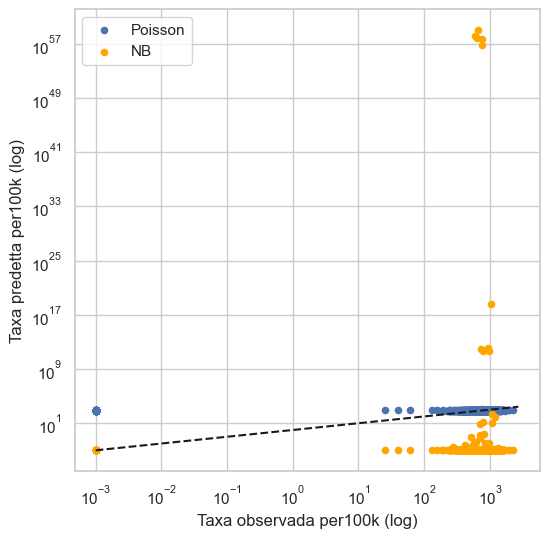

In [3]:
import numpy as np, matplotlib.pyplot as plt
# rate_obs, rate_pois, rate_nb arrays per al càlcul
eps = 1e-3
plt.figure(figsize=(6,6))
plt.scatter(rate_obs + eps, rate_pois + eps, label='Poisson', s=20)
plt.scatter(rate_obs + eps, rate_nb + eps, label='NB', s=20, color='orange')
mx = np.nanmax(rate_obs[~np.isnan(rate_obs)])*1.2
plt.plot([eps, mx+eps],[eps, mx+eps], '--', color='k')
plt.xscale('log'); plt.yscale('log')
plt.xlabel('Taxa observada per100k (log)'); plt.ylabel('Taxa predetta per100k (log)')
plt.legend()
plt.show()

In [4]:
# dispersion Poisson
pearson = (y - mu_pois) / np.sqrt(np.maximum(mu_pois, 1e-9))
dispersion = np.nansum(pearson**2) / (len(y) - (glm_poisson.df_model + 1))
print("Dispersió (Pearson) Poisson:", dispersion)
print("AIC Poisson:", glm_poisson.aic)
if nb_res is not None:
    print("AIC NB:", nb_res.aic)

Dispersió (Pearson) Poisson: 930.2116996123021
AIC Poisson: 1324823.8578744116
AIC NB: nan


C:\Users\bfeli\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:2649: RuntimeWarning: invalid value encountered in subtract
  coeff = (gamma_ln(size+endog) - gamma_ln(endog+1) -
C:\Users\bfeli\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:2651: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
C:\Users\bfeli\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:2651: RuntimeWarning: invalid value encountered in multiply
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)


In [5]:
import numpy as np, matplotlib.pyplot as plt
# obtenir coef i conf ints per models (GLM resultat)
b = glm_poisson.params; ci = glm_poisson.conf_int()
irr = np.exp(b); irr_ci = np.exp(ci)

In [6]:
import numpy as np, pandas as pd

diag = pd.read_csv("diagnostics_counts_output_fixed/diag_feminicidis.csv")  # ajusta ruta
print("n =", len(diag))
print("max y:", diag['y'].max(), "min y:", diag['y'].min())
print("max mu_pois:", np.nanmax(diag['mu_pois']), "min mu_pois:", np.nanmin(diag['mu_pois']))
print("max mu_nb:", np.nanmax(diag['mu_nb']), "min mu_nb:", np.nanmin(diag['mu_nb']))
# files amb mu_nb nan o molt petits/zeros
print(diag[diag['mu_nb'].isna()].head())
print(diag[diag['mu_nb'] < 1e-8].head())
# mirar predictors per valors extrems
df = pd.read_csv(r"C:\Users\bfeli\rates_all_metrics_cleaned.csv")
for col in ['votes_per100k_used','atur_annual_mean_pct','immigracio_per100k']:
    print(col, "min/max/median:", df[col].min(), df[col].max(), df[col].median())

n = 1092
max y: 11.0 min y: 0.0
max mu_pois: 10.838942191321312 min mu_pois: 0.0862130009269201
max mu_nb: 5.577326758325855e+55 min mu_nb: 9.325062009392349e-16
    orig_index  feminicidis  population  votes_per100k_used  \
0            1          3.0   1100954.0           70.393495   
22          25          1.0   1602174.0           44.252372   
23          26          4.0   1661660.0           42.668175   
45          50          0.0    383458.0          162.208117   
46          51          1.0    389127.0          159.844986   

    atur_annual_mean_pct  immigracio_per100k    y  mu_pois  mu_nb  rate_obs  \
0                13.7550         1654.201720  3.0      NaN    NaN       NaN   
22               10.6150        16247.673474  1.0      NaN    NaN       NaN   
23                9.6250        19356.547067  4.0      NaN    NaN       NaN   
45               10.0150         5948.761012  0.0      NaN    NaN       NaN   
46                9.1625         6771.054180  1.0      NaN    Na

In [7]:
from sklearn.preprocessing import StandardScaler
preds = ['votes_per100k_used','atur_annual_mean_pct','immigracio_per100k']
Xraw = df[preds].fillna(0).astype(float)
# log1p abans d'estandarditzar (si distribució molt asimètrica)
Xlog = np.log1p(Xraw[['votes_per100k_used','immigracio_per100k']])
Xc = Xraw.copy()
Xc['votes_per100k_used'] = Xlog['votes_per100k_used']
Xc['immigracio_per100k'] = Xlog['immigracio_per100k']
scaler = StandardScaler()
Xs = scaler.fit_transform(Xc)

In [8]:
q99 = df['votes_per100k_used'].quantile(0.99)
df['votes_capped'] = df['votes_per100k_used'].clip(upper=q99)

In [22]:
# Diagnostics Poisson + errors robusts (HC3), figures i proves de sensibilitat
# python diagnostics_poisson_hc3_A4.py

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from matplotlib.backends.backend_pdf import PdfPages

sns.set(style="whitegrid")
plt.rcParams.update({"font.size": 11})

# ---------- CONFIGURACIÓ ----------
PATH = r"C:\Users\bfeli\rates_all_metrics_by_province_year_unified_final_recomputed_rates_FIXED.csv" 
df = pd.read_csv(PATH)
df["orig_index"] = np.arange(len(df))
assert {"province", "year"}.issubset(df.columns), "Falten 'province' i/o 'year' al dataset"

OUTDIR = "output_png"
os.makedirs(OUTDIR, exist_ok=True)

# Dependent counts
DEPENDENTS_COUNTS = ["feminicidis", "denuncies", "ordres"]

# Predictor i controls
PREDICTOR = "votes_per100k_used"      # predictor final
CONTROLS = ["atur_annual_mean_pct", "immigracio_per100k"]

# Offset
OFFSET_COL = "population"

# Sensibilitat
TOP_K = 10   # excloure top-K per prova de sensibilitat

# Figures / PDF
PDF_SUMMARY = os.path.join(OUTDIR, "diagnostics_poisson_hc3_A4_vertical.pdf")
DPI = 300


def safe_log(x):
    return np.log(np.maximum(x, 1e-9))

def fit_poisson_hc3(y, X, offset):
    # Ajust Poisson i covariància robusta HC3
    glm = sm.GLM(y, X, family=sm.families.Poisson(), offset=offset)
    res = glm.fit()  # IRLS
    try:
        res_rob = res.get_robustcov_results(cov_type='HC3')
    except Exception:
        res_rob = res  
    return res, res_rob

def pearson_dispersion(y, mu, p):
    # dispersió ratio Pearson
    with np.errstate(divide='ignore', invalid='ignore'):
        pearson = (y - mu) / np.sqrt(np.maximum(mu, 1e-9))
    disp = np.nansum(pearson**2) / max(1, (len(y) - p))
    return disp, pearson

def irr_table(res_rob):
    params = res_rob.params
    cov = res_rob.cov_params()
    se = np.sqrt(np.diag(cov))
    z = 1.96
    irr = np.exp(params)
    irr_low = np.exp(params - z*se)
    irr_high = np.exp(params + z*se)
    df = pd.DataFrame({
        "term": params.index,
        "coef": params.values,
        "se": se,
        "irr": irr,
        "irr_lo": irr_low,
        "irr_hi": irr_high
    })
    return df

def plot_vertical_A4(dep, df_diag, out_png, top_indices):
    fig, axes = plt.subplots(3,1, figsize=(8.27,11.69), dpi=DPI, constrained_layout=True)
    # Panel 1: Residuals vs fitted
    ax = axes[0]
    ax.scatter(df_diag['mu_pois'], df_diag['y'] - df_diag['mu_pois'], s=28, alpha=0.75, color="#4C72B0", edgecolor='k', linewidth=0.12)
    ax.axhline(0, color='k', linestyle='--', linewidth=1)
    ax.set_xlabel("Valors ajustats (mu_poisson)")
    ax.set_ylabel("Residus (y - μ)")
    ax.set_title(f"Residuals vs Fitted (Poisson) — {dep}")
    for idx in top_indices:
        row = df_diag.loc[df_diag['orig_index'] == idx]
        if not row.empty:
            ax.annotate(str(int(idx)), (row['mu_pois'].values[0], (row['y'].values[0] - row['mu_pois'].values[0])),
                        xytext=(4,2), textcoords='offset points', fontsize=8, color='darkred')
    # Panel 2: Observed vs Predicted rates (log scale)
    ax = axes[1]
    # prepara arrays
    eps = 1e-6
    x = np.maximum(df_diag['rate_obs'].fillna(0).values, eps)
    y_p = np.maximum(df_diag['rate_pois'].fillna(0).values, eps)
    ax.scatter(x, y_p, s=28, alpha=0.7, color="#4C72B0", label="Poisson")
    mx = max(np.nanmax(x), np.nanmax(y_p)) * 1.05
    if np.isfinite(mx) and mx > 0:
        ax.plot([eps, mx], [eps, mx], linestyle='--', color='k')
    ax.set_xscale('log'); ax.set_yscale('log')
    ax.set_xlabel("Taxa observada per100k (log)")
    ax.set_ylabel("Taxa predetta per100k (log)")
    ax.set_title("Observed vs Predicted rates (per100k, log)")
    ax.legend()
    # Panel 3: Histograma Pearson residuals
    ax = axes[2]
    ax.hist(df_diag['pearson_pois'].dropna(), bins=40, color="#4C72B0", alpha=0.9)
    ax.set_xlabel("Residus de Pearson (Poisson)")
    ax.set_ylabel("Freq")
    txt = "Top influencers (orig_index): " + ", ".join(map(str, top_indices[:TOP_K]))
    ax.text(0.98, 0.02, txt, transform=ax.transAxes, ha='right', va='bottom', fontsize=9, bbox=dict(facecolor='white', alpha=0.7))
    plt.savefig(out_png, dpi=DPI, bbox_inches='tight')
    plt.close(fig)
    return out_png

# ---------- Principal ----------
df = pd.read_csv(PATH, encoding="utf-8-sig", low_memory=False)
print("Fitxer llegit:", PATH, "n =", len(df))

# comprovar columnes
needed = [OFFSET_COL, PREDICTOR] + CONTROLS + DEPENDENTS_COUNTS
miss = [c for c in needed if c not in df.columns]
if miss:
    raise SystemExit(f"Falten columnes: {miss}")

results = []
pdf = PdfPages(PDF_SUMMARY)

for dep in DEPENDENTS_COUNTS:
    print("Processant dependent:", dep)
    cols = [dep, OFFSET_COL, PREDICTOR] + CONTROLS
    sub = df[cols].dropna().copy().reset_index().rename(columns={"index":"orig_index"})
    if len(sub) < 10:
        print("  Pocs casos:", len(sub), " - saltant.")
        continue

    y = sub[dep].astype(float)
    pop = sub[OFFSET_COL].astype(float)
    offset = safe_log(pop)

    # preparar X: per defecte = predictor + controls
    X = sub[[PREDICTOR] + CONTROLS].astype(float)
    X = sm.add_constant(X, has_constant='add')

    # Prova: preprocessament per a l'estabilitat numèrica -> log1p per a predictors molt esbiaixats
    # Aplica log1p a votes_per100k_used i immigracio_per100k
    for col in [PREDICTOR, "immigracio_per100k"]:
        if col in X.columns and (X[col].max() / max(1.0, X[col].median()) > 100):
            X[col] = np.log1p(X[col])

    # Estandarditzar predictors (excepte const)
    cols_no_const = [c for c in X.columns if c != 'const']
    X.loc[:, cols_no_const] = (X[cols_no_const] - X[cols_no_const].mean()) / X[cols_no_const].std(ddof=0)

    # Fit Poisson + HC3
    try:
        res_pois, res_pois_rob = fit_poisson_hc3(y, X, offset)
    except Exception as e:
        print("  Error ajustant Poisson:", e)
        continue

    mu_pois = res_pois.predict(X, offset=offset)
    p_pois = int(res_pois.df_model + 1)
    disp_pois, pearson_pois = pearson_dispersion(y.values, mu_pois, p_pois)

    # IRR taula per a resultats robustos
    irr_df = irr_table(res_pois_rob)
    irr_df.to_csv(os.path.join(OUTDIR, f"irr_poisson_{dep}.csv"), index=False)

    # diagnostics DataFrame
    diag = sub[["orig_index"]].copy()
    diag["y"] = y.values
    diag["population"] = pop.values

    diag["mu_pois"] = mu_pois
    diag["rate_obs"]  = (diag["y"] / diag["population"]) * 100000
    diag["rate_pois"] = (diag["mu_pois"] / diag["population"]) * 100000
    diag["pearson_pois"] = pearson_pois

# --- Afegir province i year ---
# Assegura que df té orig_index
if "orig_index" not in df.columns:
    df = df.reset_index(drop=True)
    df["orig_index"] = np.arange(len(df))

# Merge per obtenir identificadors interpretables
diag = diag.merge(df[["orig_index", "province", "year"]], on="orig_index", how="left")

# Comprovar
if diag["province"].isna().any() or diag["year"].isna().any():
    missing = diag[diag["province"].isna() | diag["year"].isna()][["orig_index"]].head(10)
    raise ValueError(f"No s'han pogut recuperar province/year per alguns orig_index. Exemples:\n{missing}")

# Etiqueta útil per a plots
diag["prov_year"] = diag["province"].astype(str) + "–" + diag["year"].astype(int).astype(str)

# Alineació
assert len(mu_pois) == len(diag), "mu_pois no està alineat amb diag"

    # Desar diag
diag_path = os.path.join(OUTDIR, f"diag_{dep}.csv")
diag.to_csv(diag_path, index=False)

    # principals influencers segons absolute Pearson
top_idx = diag.reindex(diag['pearson_pois'].abs().sort_values(ascending=False).index)['orig_index'].head(TOP_K).tolist()

def plot_vertical_A4(dep, df_diag, out_png, top_indices):
    # --- assegura etiqueta província–any si tens camps ---
    if "prov_year" not in df_diag.columns:
        if ("province" in df_diag.columns) and ("year" in df_diag.columns):
            df_diag = df_diag.copy()
            df_diag["prov_year"] = df_diag["province"].astype(str) + "–" + df_diag["year"].astype(int).astype(str)

    def label_for_idx(idx):
        # torna prov_year si existeix per aquest idx; si no, orig_index
        row = df_diag.loc[df_diag["orig_index"] == idx]
        if row.empty:
            return str(int(idx))
        if "prov_year" in df_diag.columns and pd.notna(row["prov_year"].values[0]):
            return str(row["prov_year"].values[0])
        return str(int(idx))

    fig, axes = plt.subplots(3, 1, figsize=(8.27, 11.69), dpi=DPI, constrained_layout=True)

    # Panel 1: Residuals vs fitted
    ax = axes[0]
    ax.scatter(
        df_diag["mu_pois"],
        df_diag["y"] - df_diag["mu_pois"],
        s=28, alpha=0.75, color="#4C72B0", edgecolor="k", linewidth=0.12
    )
    ax.axhline(0, color="k", linestyle="--", linewidth=1)
    ax.set_xlabel("Valors ajustats (μ Poisson)")
    ax.set_ylabel("Residus (y − μ)")
    ax.set_title(f"Residuals vs Fitted (Poisson) — {dep}")

    for idx in top_indices:
        row = df_diag.loc[df_diag["orig_index"] == idx]
        if not row.empty:
            ax.annotate(
                label_for_idx(idx),
                (row["mu_pois"].values[0], (row["y"].values[0] - row["mu_pois"].values[0])),
                xytext=(4, 2), textcoords="offset points",
                fontsize=8, color="darkred"
            )

    # Panel 2: Observed vs Predicted rates (log-log)
    ax = axes[1]
    eps = 1e-6
    x = np.maximum(df_diag["rate_obs"].fillna(0).values, eps)
    y_p = np.maximum(df_diag["rate_pois"].fillna(0).values, eps)

    ax.scatter(x, y_p, s=28, alpha=0.7, color="#4C72B0", label="Poisson")
    mx = max(np.nanmax(x), np.nanmax(y_p)) * 1.05
    if np.isfinite(mx) and mx > 0:
        ax.plot([eps, mx], [eps, mx], linestyle="--", color="k")

    ax.set_xscale("log"); ax.set_yscale("log")
    ax.set_xlabel("Taxa observada per 100k (eix X en log)")
    ax.set_ylabel("Taxa predita per 100k (eix Y en log)")
    ax.set_title("Observed vs Predicted rates (per 100k; eixos log-log)")
    ax.legend()

    if ("province" not in df_diag.columns) or ("year" not in df_diag.columns):
        if "orig_index" not in df.columns:
            df = df.reset_index(drop=True)
            df["orig_index"] = np.arange(len(df))
        df_diag = df_diag.merge(df[["orig_index","province","year"]], on="orig_index", how="left")

    # Panel 3: Histograma Pearson residuals
    ax = axes[2]
    ax.hist(df_diag["pearson_pois"].dropna(), bins=40, color="#4C72B0", alpha=0.9)
    ax.set_xlabel("Residus de Pearson (Poisson)")
    ax.set_ylabel("Freqüència")

    top_labels = ", ".join(label_for_idx(i) for i in top_indices[:TOP_K])
    txt = "Top influencers: " + top_labels
    ax.text(0.98, 0.02, txt, transform=ax.transAxes, ha="right", va="bottom",
            fontsize=9, bbox=dict(facecolor="white", alpha=0.7))

    fig.savefig(out_png, dpi=DPI, bbox_inches="tight")
    return fig

    # Resum
    results.append({
        "dependent": dep,
        "n": len(y),
        "aic_poisson": float(res_pois.aic),
        "llf_poisson": float(res_pois.llf),
        "dispersion_poisson": float(disp_pois),
        "dispersion_poisson_no_topK": float(disp2)
    })

    print(f"  {dep}: n={len(y)} disp={disp_pois:.3f} AIC={res_pois.aic:.2f}")

# desar PNG
out_dir = os.path.dirname(out_png)
if out_dir:
    os.makedirs(out_dir, exist_ok=True)

print("Saving PNG to:", os.path.abspath(out_png))
fig.savefig(out_png, dpi=DPI, bbox_inches="tight")

plt.close(fig)  # important si estàs en un bucle

print("Saved OK?", os.path.isfile(out_png))

pd.DataFrame(results).to_csv(os.path.join(OUTDIR, "models_summary_poisson_hc3.csv"), index=False)
print("Processament complet. Resultats a:", OUTDIR)

Fitxer llegit: C:\Users\bfeli\rates_all_metrics_by_province_year_unified_final_recomputed_rates_FIXED.csv n = 1196
Processant dependent: feminicidis
Processant dependent: denuncies
Processant dependent: ordres
Saving PNG to: C:\Users\bfeli\forest_irr_feminicidis.png
Saved OK? True
Processament complet. Resultats a: output_png


In [23]:
# Diagnostics Poisson + HC3 amb plotting de residus millorat (etiquetes petites i no solapades)
# python diagnostics_poisson_hc3_A4_fixed_labels.py

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from matplotlib.backends.backend_pdf import PdfPages

sns.set(style="whitegrid")
plt.rcParams.update({"font.size": 11})

# ---------- CONFIGURACIÓ ----------
PATH = r"C:\Users\bfeli\rates_all_metrics_cleaned.csv" 
OUTDIR = "diagnostics_poisson_hc3_output_fixed_labels"
os.makedirs(OUTDIR, exist_ok=True)

DEPENDENTS_COUNTS = ["feminicidis", "denuncies", "ordres"]
PREDICTOR = "votes_per100k_used"
CONTROLS = ["atur_annual_mean_pct", "immigracio_per100k"]
OFFSET_COL = "population"
TOP_K = 10
PDF_SUMMARY = os.path.join(OUTDIR, "diagnostics_poisson_hc3_A4_vertical_fixed_labels.pdf")
DPI = 300


def safe_log(x):
    return np.log(np.maximum(x, 1e-9))

def fit_poisson_hc3(y, X, offset):
    glm = sm.GLM(y, X, family=sm.families.Poisson(), offset=offset)
    res = glm.fit()
    try:
        res_rob = res.get_robustcov_results(cov_type='HC3')
    except Exception:
        res_rob = res
    return res, res_rob

def pearson_dispersion(y, mu, p):
    with np.errstate(divide='ignore', invalid='ignore'):
        pearson = (y - mu) / np.sqrt(np.maximum(mu, 1e-9))
    disp = np.nansum(pearson**2) / max(1, (len(y) - p))
    return disp, pearson

def irr_table(res_rob):
    params = res_rob.params
    cov = res_rob.cov_params()
    se = np.sqrt(np.diag(cov))
    z = 1.96
    irr = np.exp(params)
    irr_low = np.exp(params - z*se)
    irr_high = np.exp(params + z*se)
    df = pd.DataFrame({
        "term": params.index,
        "coef": params.values,
        "se": se,
        "irr": irr,
        "irr_lo": irr_low,
        "irr_hi": irr_high
    })
    return df

# --------- Dibuixar el panell de Residuals vs Fitted sobre un axis ----------
def draw_residuals_panel(ax, df_diag, fitted_col="mu_pois", y_col="y", index_col="orig_index",
                         top_k=5, y_lim=6, min_abs_pearson_to_label=2.5):

    eps = 1e-9
    df = df_diag.copy().reset_index(drop=True)

    # calcular pearson 
    if "pearson_pois" not in df.columns:
        mu = df[fitted_col].astype(float).values
        y = df[y_col].astype(float).values
        pearson = (y - mu) / np.sqrt(np.maximum(mu, eps))
        df["pearson_pois"] = pearson

    x = df[fitted_col].astype(float).values
    yres = df["pearson_pois"].astype(float).values

    # primer definim límits visuals raonables (percentils)
    try:
        xmin_pct, xmax_pct = np.nanpercentile(x, [1.0, 99.0])
    except Exception:
        xmin_pct, xmax_pct = np.nanmin(x), np.nanmax(x)
    try:
        ymin_pct, ymax_pct = np.nanpercentile(yres, [1.0, 99.0])
    except Exception:
        ymin_pct, ymax_pct = -y_lim, y_lim

    # ampliar una mica els límits per marge
    x_margin = max((xmax_pct - xmin_pct) * 0.04, 1e-6)
    y_margin = max((ymax_pct - ymin_pct) * 0.08, 0.5)

    x_left = max(xmin_pct - x_margin, np.nanmin(x))
    x_right = min(xmax_pct + x_margin, np.nanmax(x) if np.isfinite(np.nanmax(x)) else xmax_pct + x_margin)
    y_bottom = min(ymin_pct - y_margin, -y_lim)
    y_top = max(ymax_pct + y_margin, y_lim)

    # establir límits abans de plotar i anotacions (això evita que get_xlim doni valors inesperats)
    ax.set_xlim(left=x_left, right=x_right)
    ax.set_ylim(bottom=y_bottom, top=y_top)

    # jitter x per reduir sobreposició
    rng = np.random.default_rng(42)
    x_range = x_right - x_left if (x_right > x_left) else 1.0
    jitter_scale = x_range * 0.006
    x_jitter = x + rng.normal(scale=jitter_scale, size=len(x))

    # dibuixar punts
    ax.scatter(x_jitter, yres, s=14, alpha=0.6, color="#2A6F97", edgecolors='none')
    ax.axhline(0, color='k', linestyle='--', linewidth=1)
    ax.axhline(2, color='tab:orange', linestyle=':', linewidth=0.9)
    ax.axhline(-2, color='tab:orange', linestyle=':', linewidth=0.9)
    ax.axhline(3, color='red', linestyle=':', linewidth=0.9)
    ax.axhline(-3, color='red', linestyle=':', linewidth=0.9)
    ax.grid(axis='y', linestyle=':', linewidth=0.4)

    # seleccionar candidats per etiquetar: top_k per abs pearson però també filtrant amb min_abs_pearson_to_label
    df["abs_pearson"] = np.abs(df["pearson_pois"])
    candidates = df[df["abs_pearson"] >= min_abs_pearson_to_label]
    if len(candidates) == 0:
        candidates = df.nlargest(top_k, "abs_pearson")
    else:
        candidates = candidates.nlargest(top_k, "abs_pearson")

    fontsize_label = 7
    placed_y = []

    for _, row in candidates.iterrows():
        xi = float(row[fitted_col])
        yi = float(row["pearson_pois"])
        label = str(int(row[index_col])) if index_col in row else ""

        # coordenades de text inicial (intents pos i pos)
        x_text = xi
        y_text = yi

        # comprobar si el punt està dins els límits; si surt, es marca i es col·loca etiqueta al marge amb fletxa
        out_right = xi > x_right
        out_left = xi < x_left
        out_top = yi > y_top
        out_bottom = yi < y_bottom

        # si està dins, intentem posar l'etiqueta prop del punt amb petit offset,
        # i si s'obre solapament, movem verticalment (bucle simple)
        if not (out_right or out_left or out_top or out_bottom):
            # offset lleuger a la dreta
            x_text = xi + 0.01 * x_range
            y_text = yi
            # evitar solapaments verticals
            tries = 0
            vgap = max(0.06, 0.04 * (y_top - y_bottom))
            while any(abs(y_text - py) < vgap for py in placed_y) and tries < 50:
                y_text += vgap * (1 if (tries % 2 == 0) else -1) * (tries//2 + 1)
                tries += 1
            # limitar dins y límits
            if y_text > (y_top - 0.02*(y_top - y_bottom)):
                y_text = y_top - 0.02*(y_top - y_bottom)
            if y_text < (y_bottom + 0.02*(y_top - y_bottom)):
                y_text = y_bottom + 0.02*(y_top - y_bottom)

            ha = 'left'
            va = 'center'
            ax.text(x_text, y_text, label, fontsize=fontsize_label, color='darkred',
                    ha=ha, va=va, bbox=dict(facecolor='white', alpha=0.7, pad=0.3))
            placed_y.append(y_text)

        else:
            # punt fora: col·loquem l'etiqueta a la vora corresponent i dibuixem una fletxa
            # si punt a la dreta o xi està molt prop del marge dret -> etiqueta dret, amb arrow cap al punt
            if out_right:
                x_text = x_right - 0.01 * x_range
                ha = 'right'
            elif out_left:
                x_text = x_left + 0.01 * x_range
                ha = 'left'
            else:
                # si està dins en x però fora en y, posarem a l'interior en x i al top/bottom per y
                x_text = np.clip(xi, x_left + 0.02*x_range, x_right - 0.02*x_range)
                ha = 'center'

            # y_text posat al marge vertical corresponent
            if out_top:
                y_text = y_top - 0.02*(y_top - y_bottom)
            elif out_bottom:
                y_text = y_bottom + 0.02*(y_top - y_bottom)

            va = 'center'
            # dibuixar text i arrow
            ax.annotate(label, xy=(xi, yi), xytext=(x_text, y_text),
                        fontsize=fontsize_label, color='darkred',
                        ha=ha, va=va,
                        bbox=dict(facecolor='white', alpha=0.8, pad=0.3),
                        arrowprops=dict(arrowstyle='->', color='gray', lw=0.6, alpha=0.8))
            placed_y.append(y_text)

    ax.set_xlabel(f"Valors ajustats ({fitted_col})")
    ax.set_ylabel("Residus de Pearson")
    ax.set_title(f"Residuals vs Fitted (Poisson)")
    return ax

# ---------- Principal ----------
df = pd.read_csv(PATH, encoding="utf-8-sig", low_memory=False)
print("Fitxer llegit:", PATH, "n =", len(df))

needed = [OFFSET_COL, PREDICTOR] + CONTROLS + DEPENDENTS_COUNTS
miss = [c for c in needed if c not in df.columns]
if miss:
    raise SystemExit(f"Falten columnes: {miss}")

results = []
pdf = PdfPages(PDF_SUMMARY)

for dep in DEPENDENTS_COUNTS:
    print("Processant dependent:", dep)
    cols = [dep, OFFSET_COL, PREDICTOR] + CONTROLS
    sub = df[cols].dropna().copy().reset_index().rename(columns={"index":"orig_index"})
    if len(sub) < 10:
        print("  Pocs casos:", len(sub), " - saltant.")
        continue

    y = sub[dep].astype(float)
    pop = sub[OFFSET_COL].astype(float)
    offset = safe_log(pop)

    # preparar X
    X = sub[[PREDICTOR] + CONTROLS].astype(float)
    X = sm.add_constant(X, has_constant='add')

    # preprocessar numèric senzill
    for col in [PREDICTOR, "immigracio_per100k"]:
        if col in X.columns and (X[col].max() / max(1.0, abs(X[col].median())) > 100):
            X[col] = np.log1p(X[col])

    cols_no_const = [c for c in X.columns if c != 'const']
    X.loc[:, cols_no_const] = (X[cols_no_const] - X[cols_no_const].mean()) / X[cols_no_const].std(ddof=0)

    # ajustar Poisson + HC3
    try:
        res_pois, res_pois_rob = fit_poisson_hc3(y, X, offset)
    except Exception as e:
        print("  Error ajustant Poisson:", e)
        continue

    mu_pois = res_pois.predict(X, offset=offset)
    p_pois = int(res_pois.df_model + 1)
    disp_pois, pearson_pois = pearson_dispersion(y.values, mu_pois, p_pois)

    irr_df = irr_table(res_pois_rob)
    irr_df.to_csv(os.path.join(OUTDIR, f"irr_poisson_{dep}.csv"), index=False)

    # diagnostics DataFrame
    diag = sub[['orig_index']].copy()
    diag['y'] = y.values
    diag['population'] = pop.values
    diag['mu_pois'] = mu_pois
    diag['rate_obs'] = (y.values / pop.values) * 100000
    diag['rate_pois'] = (mu_pois / pop.values) * 100000
    diag['pearson_pois'] = pearson_pois
    diag_path = os.path.join(OUTDIR, f"diag_{dep}.csv")
    diag.to_csv(diag_path, index=False)

    top_idx = diag.reindex(diag['pearson_pois'].abs().sort_values(ascending=False).index)['orig_index'].head(TOP_K).tolist()

    # Generar figura vertical A4: utilitzar draw_residuals_panel per al primer panell
    fig, axes = plt.subplots(3, 1, figsize=(8.27, 11.69), dpi=DPI, constrained_layout=True)

    # Primer panell: Residuals vs Fitted amb la nova funció (etiquetes petites/no solapants)
    draw_residuals_panel(axes[0], diag, fitted_col='mu_pois', y_col='y', index_col='orig_index', top_k=TOP_K, y_lim=6)

    # Segon panell: Observed vs Predicted rates (log)
    ax = axes[1]
    eps = 1e-6
    x = np.maximum(diag['rate_obs'].fillna(eps).values, eps)
    y_p = np.maximum(diag['rate_pois'].fillna(eps).values, eps)
    ax.scatter(x, y_p, s=28, alpha=0.7, color="#4C72B0", label="Poisson")
    mx = max(np.nanmax(x), np.nanmax(y_p)) * 1.05
    if np.isfinite(mx) and mx > 0:
        ax.plot([eps, mx], [eps, mx], linestyle='--', color='k')
    ax.set_xscale('log'); ax.set_yscale('log')
    ax.set_xlabel("Taxa observada per100k (log)")
    ax.set_ylabel("Taxa predetta per100k (log)")
    ax.set_title("Observed vs Predicted rates (per100k, log)")
    ax.legend()

    # Tercer panell: histograma residus de Pearson amb top influencers
    ax = axes[2]
    ax.hist(diag['pearson_pois'].dropna(), bins=40, color="#4C72B0", alpha=0.9)
    ax.set_xlabel("Residus de Pearson (Poisson)")
    ax.set_ylabel("Freq")
    txt = "Top influencers (orig_index): " + ", ".join(map(str, top_idx[:TOP_K]))
    ax.text(0.98, 0.02, txt, transform=ax.transAxes, ha='right', va='bottom', fontsize=9, bbox=dict(facecolor='white', alpha=0.7))

    # desar PNG
    png_path = os.path.join(OUTDIR, f"diagnostics_{dep}.png")
    fig.savefig(png_path, dpi=DPI, bbox_inches='tight')
    pdf.savefig(fig)
    plt.close(fig)

    # Sensibilitat: excloure top-K i refit Poisson+HC3
    mask_keep = ~diag['orig_index'].isin(top_idx)
    y2 = y.values[mask_keep]
    X2 = X.loc[mask_keep.values, :].copy()
    offset2 = offset[mask_keep.values]
    if len(y2) >= max(10, X2.shape[1] + 1):
        try:
            res2, res2_rob = fit_poisson_hc3(y2, X2, offset2)
            mu2 = res2.predict(X2, offset=offset2)
            disp2, _ = pearson_dispersion(y2, mu2, int(res2.df_model + 1))
            irr2 = irr_table(res2_rob)
            irr2.to_csv(os.path.join(OUTDIR, f"irr_poisson_{dep}_no_top{TOP_K}.csv"), index=False)
        except Exception as e:
            print("  L'anàlisi de sensibilitat ha fallat per", dep, e)
            disp2 = np.nan
    else:
        disp2 = np.nan

    results.append({
        "dependent": dep,
        "n": len(y),
        "aic_poisson": float(res_pois.aic),
        "llf_poisson": float(res_pois.llf),
        "dispersion_poisson": float(disp_pois),
        "dispersion_poisson_no_topK": float(disp2)
    })

    print(f"  {dep}: n={len(y)} disp={disp_pois:.3f} AIC={res_pois.aic:.2f}")

pdf.close()
pd.DataFrame(results).to_csv(os.path.join(OUTDIR, "models_summary_poisson_hc3_fixed_labels.csv"), index=False)
print("Processament complet. Resultats a:", OUTDIR)

Fitxer llegit: C:\Users\bfeli\rates_all_metrics_cleaned.csv n = 1196
Processant dependent: feminicidis
  feminicidis: n=1092 disp=1.141 AIC=2603.46
Processant dependent: denuncies
  denuncies: n=1092 disp=3085.336 AIC=3391711.84
Processant dependent: ordres
  ordres: n=1092 disp=929.716 AIC=1321349.16
Processament complet. Resultats a: diagnostics_poisson_hc3_output_fixed_labels


In [24]:
# Diagnostics Poisson + HC3 amb plotting de residus millorat (etiquetes petites i no solapants)
# i generació de taules Quasi-Poisson (IRR amb SE escalats per dispersió)
# python diagnostics_poisson_hc3_A4_fixed_labels_quasipoisson.py

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from matplotlib.backends.backend_pdf import PdfPages

sns.set(style="whitegrid")
plt.rcParams.update({"font.size": 11})

# ---------- CONFIGURACIÓ ----------
PATH = r"C:\Users\bfeli\rates_all_metrics_cleaned.csv"   
OUTDIR = "diagnostics_poisson_hc3_output_fixed_labels_quasipoisson"
os.makedirs(OUTDIR, exist_ok=True)

DEPENDENTS_COUNTS = ["feminicidis", "denuncies", "ordres"]
PREDICTOR = "votes_per100k_used"
CONTROLS = ["atur_annual_mean_pct", "immigracio_per100k"]
OFFSET_COL = "population"

# plotting / sensitivity
TOP_K = 3   
MIN_ABS_PEARSON_TO_LABEL = 3.0  # només etiquetar si |pearson| >= 3.0
PDF_SUMMARY = os.path.join(OUTDIR, "diagnostics_poisson_hc3_A4_vertical_fixed_labels_quasipoisson.pdf")
DPI = 300


def safe_log(x):
    return np.log(np.maximum(x, 1e-9))

def fit_poisson_hc3(y, X, offset):
    glm = sm.GLM(y, X, family=sm.families.Poisson(), offset=offset)
    res = glm.fit()
    try:
        res_rob = res.get_robustcov_results(cov_type='HC3')
    except Exception:
        res_rob = res
    return res, res_rob

def pearson_dispersion(y, mu, p):
    with np.errstate(divide='ignore', invalid='ignore'):
        pearson = (y - mu) / np.sqrt(np.maximum(mu, 1e-9))
    disp = np.nansum(pearson**2) / max(1, (len(y) - p))
    return disp, pearson

def irr_table_from_res_rob(res_rob):
    params = res_rob.params
    cov = res_rob.cov_params()
    se = np.sqrt(np.diag(cov))
    z = 1.96
    irr = np.exp(params)
    irr_low = np.exp(params - z*se)
    irr_high = np.exp(params + z*se)
    df = pd.DataFrame({
        "term": params.index,
        "coef": params.values,
        "se": se,
        "irr": irr,
        "irr_lo": irr_low,
        "irr_hi": irr_high
    })
    return df

def irr_table_quasipoisson(res_pois, dispersion):
    params = res_pois.params
    cov = res_pois.cov_params() * dispersion
    se = np.sqrt(np.diag(cov))
    z = 1.96
    irr = np.exp(params)
    irr_low = np.exp(params - z*se)
    irr_high = np.exp(params + z*se)
    df = pd.DataFrame({
        "term": params.index,
        "coef": params.values,
        "se_quasi": se,
        "irr_quasi": irr,
        "irr_quasi_lo": irr_low,
        "irr_quasi_hi": irr_high
    })
    return df

# --------- Dibuixar panel 1: Residuals vs Fitted (millorada) ------------
def draw_residuals_panel(ax, df_diag, fitted_col="mu_pois", y_col="y", index_col="orig_index",
                         top_k=3, y_lim=6, min_abs_pearson_to_label=3.0):
    eps = 1e-9
    df = df_diag.copy().reset_index(drop=True)

    # calcular pearson
    if "pearson_pois" not in df.columns:
        mu = df[fitted_col].astype(float).values
        y = df[y_col].astype(float).values
        pearson = (y - mu) / np.sqrt(np.maximum(mu, eps))
        df["pearson_pois"] = pearson

    x = df[fitted_col].astype(float).values
    yres = df["pearson_pois"].astype(float).values

    # definir límits raonables per percentils 
    try:
        xmin_pct, xmax_pct = np.nanpercentile(x, [1.0, 99.0])
    except Exception:
        xmin_pct, xmax_pct = np.nanmin(x), np.nanmax(x)
    try:
        ymin_pct, ymax_pct = np.nanpercentile(yres, [1.0, 99.0])
    except Exception:
        ymin_pct, ymax_pct = -y_lim, y_lim

    x_margin = max((xmax_pct - xmin_pct) * 0.04, 1e-6)
    y_margin = max((ymax_pct - ymin_pct) * 0.08, 0.5)

    x_left = max(xmin_pct - x_margin, np.nanmin(x))
    x_right = min(xmax_pct + x_margin, np.nanmax(x) if np.isfinite(np.nanmax(x)) else xmax_pct + x_margin)
    y_bottom = min(ymin_pct - y_margin, -y_lim)
    y_top = max(ymax_pct + y_margin, y_lim)

    ax.set_xlim(left=x_left, right=x_right)
    ax.set_ylim(bottom=y_bottom, top=y_top)

    # jitter x per reduir sobreposició
    rng = np.random.default_rng(42)
    x_range = x_right - x_left if (x_right > x_left) else 1.0
    jitter_scale = x_range * 0.006
    x_jitter = x + rng.normal(scale=jitter_scale, size=len(x))

    ax.scatter(x_jitter, yres, s=14, alpha=0.6, color="#2A6F97", edgecolors='none')
    ax.axhline(0, color='k', linestyle='--', linewidth=1)
    ax.axhline(2, color='tab:orange', linestyle=':', linewidth=0.9)
    ax.axhline(-2, color='tab:orange', linestyle=':', linewidth=0.9)
    ax.axhline(3, color='red', linestyle=':', linewidth=0.9)
    ax.axhline(-3, color='red', linestyle=':', linewidth=0.9)
    ax.grid(axis='y', linestyle=':', linewidth=0.4)

    # seleccionar candidats (filtrar per llindar i triar top_k)
    df["abs_pearson"] = np.abs(df["pearson_pois"])
    candidates = df[df["abs_pearson"] >= min_abs_pearson_to_label]
    if len(candidates) == 0:
        candidates = df.nlargest(top_k, "abs_pearson")
    else:
        candidates = candidates.nlargest(top_k, "abs_pearson")

    fontsize_label = 7
    placed_y = []

    for _, row in candidates.iterrows():
        xi = float(row[fitted_col])
        yi = float(row["pearson_pois"])
        label = str(int(row[index_col])) if index_col in row else ""

        x_text = xi
        y_text = yi

        out_right = xi > x_right
        out_left = xi < x_left
        out_top = yi > y_top
        out_bottom = yi < y_bottom

        if not (out_right or out_left or out_top or out_bottom):
            x_text = xi + 0.01 * x_range
            y_text = yi
            tries = 0
            vgap = max(0.06, 0.04 * (y_top - y_bottom))
            while any(abs(y_text - py) < vgap for py in placed_y) and tries < 50:
                y_text += vgap * (1 if (tries % 2 == 0) else -1) * (tries//2 + 1)
                tries += 1
            if y_text > (y_top - 0.02*(y_top - y_bottom)):
                y_text = y_top - 0.02*(y_top - y_bottom)
            if y_text < (y_bottom + 0.02*(y_top - y_bottom)):
                y_text = y_bottom + 0.02*(y_top - y_bottom)
            ha = 'left'; va = 'center'
            ax.text(x_text, y_text, label, fontsize=fontsize_label, color='darkred',
                    ha=ha, va=va, bbox=dict(facecolor='white', alpha=0.7, pad=0.3))
            placed_y.append(y_text)
        else:
            if out_right:
                x_text = x_right - 0.01 * x_range
                ha = 'right'
            elif out_left:
                x_text = x_left + 0.01 * x_range
                ha = 'left'
            else:
                x_text = np.clip(xi, x_left + 0.02*x_range, x_right - 0.02*x_range)
                ha = 'center'

            if out_top:
                y_text = y_top - 0.02*(y_top - y_bottom)
            elif out_bottom:
                y_text = y_bottom + 0.02*(y_top - y_bottom)

            va = 'center'
            ax.annotate(label, xy=(xi, yi), xytext=(x_text, y_text),
                        fontsize=fontsize_label, color='darkred',
                        ha=ha, va=va,
                        bbox=dict(facecolor='white', alpha=0.8, pad=0.3),
                        arrowprops=dict(arrowstyle='->', color='gray', lw=0.6, alpha=0.8))
            placed_y.append(y_text)

    ax.set_xlabel(f"Valors ajustats ({fitted_col})")
    ax.set_ylabel("Residus de Pearson")
    ax.set_title(f"Residuals vs Fitted (Poisson)")
    return ax

df = pd.read_csv(PATH, encoding="utf-8-sig", low_memory=False)
print("Fitxer llegit:", PATH, "n =", len(df))

needed = [OFFSET_COL, PREDICTOR] + CONTROLS + DEPENDENTS_COUNTS
miss = [c for c in needed if c not in df.columns]
if miss:
    raise SystemExit(f"Falten columnes: {miss}")

results = []
pdf = PdfPages(PDF_SUMMARY)

for dep in DEPENDENTS_COUNTS:
    print("Processant dependent:", dep)
    cols = [dep, OFFSET_COL, PREDICTOR] + CONTROLS
    sub = df[cols].dropna().copy().reset_index().rename(columns={"index":"orig_index"})
    if len(sub) < 10:
        print("  Pocs casos:", len(sub), " - saltant.")
        continue

    y = sub[dep].astype(float)
    pop = sub[OFFSET_COL].astype(float)
    offset = safe_log(pop)

    # preparar X
    X = sub[[PREDICTOR] + CONTROLS].astype(float)
    X = sm.add_constant(X, has_constant='add')

    # preprocessar numèric senzill: log1p per fortament asimètrics
    for col in [PREDICTOR, "immigracio_per100k"]:
        if col in X.columns and (X[col].max() / max(1.0, abs(X[col].median())) > 100):
            X[col] = np.log1p(X[col])

    cols_no_const = [c for c in X.columns if c != 'const']
    X.loc[:, cols_no_const] = (X[cols_no_const] - X[cols_no_const].mean()) / X[cols_no_const].std(ddof=0)

    # ajustar Poisson + HC3
    try:
        res_pois, res_pois_rob = fit_poisson_hc3(y, X, offset)
    except Exception as e:
        print("  Error ajustant Poisson:", e)
        continue

    mu_pois = res_pois.predict(X, offset=offset)
    p_pois = int(res_pois.df_model + 1)
    disp_pois, pearson_pois = pearson_dispersion(y.values, mu_pois, p_pois)

    # guardar IRR Poisson (robust) i IRR quasi-Poisson escalat
    irr_poisson_df = irr_table_from_res_rob(res_pois_rob)
    irr_poisson_df.to_csv(os.path.join(OUTDIR, f"irr_poisson_{dep}.csv"), index=False)

    irr_quasi_df = irr_table_quasipoisson(res_pois, disp_pois)
    irr_quasi_df.to_csv(os.path.join(OUTDIR, f"irr_quasi_poisson_{dep}.csv"), index=False)

    # diagnostics DataFrame
    diag = sub[['orig_index']].copy()
    diag['y'] = y.values
    diag['population'] = pop.values
    diag['mu_pois'] = mu_pois
    diag['rate_obs'] = (y.values / pop.values) * 100000
    diag['rate_pois'] = (mu_pois / pop.values) * 100000
    diag['pearson_pois'] = pearson_pois
    diag_path = os.path.join(OUTDIR, f"diag_{dep}.csv")
    diag.to_csv(diag_path, index=False)

    # top influencers basats en pearson
    top_idx = diag.reindex(diag['pearson_pois'].abs().sort_values(ascending=False).index)['orig_index'].head(TOP_K).tolist()

    # Generar figura vertical A4 amb la nova funció d'etiquetatge
    fig, axes = plt.subplots(3, 1, figsize=(8.27, 11.69), dpi=DPI, constrained_layout=True)
    draw_residuals_panel(axes[0], diag, fitted_col='mu_pois', y_col='y', index_col='orig_index',
                         top_k=TOP_K, y_lim=6, min_abs_pearson_to_label=MIN_ABS_PEARSON_TO_LABEL)

    # Observed vs Predicted rates (log)
    ax = axes[1]
    eps = 1e-6
    x = np.maximum(diag['rate_obs'].fillna(eps).values, eps)
    y_p = np.maximum(diag['rate_pois'].fillna(eps).values, eps)
    ax.scatter(x, y_p, s=28, alpha=0.7, color="#4C72B0", label="Poisson")
    mx = max(np.nanmax(x), np.nanmax(y_p)) * 1.05
    if np.isfinite(mx) and mx > 0:
        ax.plot([eps, mx], [eps, mx], linestyle='--', color='k')
    ax.set_xscale('log'); ax.set_yscale('log')
    ax.set_xlabel("Taxa observada per100k (log)")
    ax.set_ylabel("Taxa predicció per100k (log)")
    ax.set_title("Observed vs Predicted rates (per100k, log)")
    ax.legend()

    # Histograma residus
    ax = axes[2]
    ax.hist(diag['pearson_pois'].dropna(), bins=40, color="#4C72B0", alpha=0.9)
    ax.set_xlabel("Residus de Pearson (Poisson)")
    ax.set_ylabel("Freq")
    txt = "Top influencers (orig_index): " + ", ".join(map(str, top_idx[:TOP_K]))
    ax.text(0.98, 0.02, txt, transform=ax.transAxes, ha='right', va='bottom', fontsize=9, bbox=dict(facecolor='white', alpha=0.7))

    # desar PNG
    png_path = os.path.join(OUTDIR, f"diagnostics_{dep}.png")
    fig.savefig(png_path, dpi=DPI, bbox_inches='tight')
    pdf.savefig(fig)
    plt.close(fig)

    # Sensibilitat: excloure top-K i refit Poisson+HC3
    mask_keep = ~diag['orig_index'].isin(top_idx)
    y2 = y.values[mask_keep]
    X2 = X.loc[mask_keep.values, :].copy()
    offset2 = offset[mask_keep.values]
    if len(y2) >= max(10, X2.shape[1] + 1):
        try:
            res2, res2_rob = fit_poisson_hc3(y2, X2, offset2)
            mu2 = res2.predict(X2, offset=offset2)
            disp2, _ = pearson_dispersion(y2, mu2, int(res2.df_model + 1))
            irr2 = irr_table_from_res_rob(res2_rob)
            irr2.to_csv(os.path.join(OUTDIR, f"irr_poisson_{dep}_no_top{TOP_K}.csv"), index=False)
        except Exception as e:
            print("  L'anàlisi de sensibilitat ha fallat a", dep, e)
            disp2 = np.nan
    else:
        disp2 = np.nan

    results.append({
        "dependent": dep,
        "n": len(y),
        "aic_poisson": float(res_pois.aic),
        "llf_poisson": float(res_pois.llf),
        "dispersion_poisson": float(disp_pois),
        "dispersion_poisson_no_topK": float(disp2)
    })

    print(f"  {dep}: n={len(y)} disp={disp_pois:.3f} AIC={res_pois.aic:.2f}")

pdf.close()
pd.DataFrame(results).to_csv(os.path.join(OUTDIR, "models_summary_poisson_hc3_fixed_labels_quasipoisson.csv"), index=False)
print("Processament complet. Resultats a:", OUTDIR)

Fitxer llegit: C:\Users\bfeli\rates_all_metrics_cleaned.csv n = 1196
Processant dependent: feminicidis
  feminicidis: n=1092 disp=1.141 AIC=2603.46
Processant dependent: denuncies
  denuncies: n=1092 disp=3085.336 AIC=3391711.84
Processant dependent: ordres
  ordres: n=1092 disp=929.716 AIC=1321349.16
Processament complet. Resultats a: diagnostics_poisson_hc3_output_fixed_labels_quasipoisson


In [25]:
# assumir res_pois (Poisson fit) existeix i X, y, offset definits
start = res_pois.params
glm_nb = sm.GLM(y, X, family=sm.families.NegativeBinomial(), offset=offset)
nb_res = glm_nb.fit(start_params=start, maxiter=500, method='newton')  # prova newton
print(nb_res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 ordres   No. Observations:                 1092
Model:                            GLM   Df Residuals:                     1088
Model Family:        NegativeBinomial   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                        newton   Log-Likelihood:                -10127.
Date:                Sun, 21 Dec 2025   Deviance:                       1107.9
Time:                        13:00:44   Pearson chi2:                     204.
No. Iterations:                     4   Pseudo R-squ. (CS):            0.02414
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -4.9550 

In [26]:
# fit_nb_pipeline.py
# Ajustar Negative Binomial (GLM family) per a "denuncies" i "ordres"

import os
import sys
import traceback
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# CONFIGURACIÓ ------------------------------------------------
PATH = r"C:\Users\bfeli\rates_all_metrics_cleaned.csv" 
OUTDIR = "nb_attempt_results"
os.makedirs(OUTDIR, exist_ok=True)

DEPENDENTS = ["denuncies", "ordres"]
PREDICTORS = ["votes_per100k_used", "atur_annual_mean_pct", "immigracio_per100k"]
OFFSET_COL = "population"
MIN_POP = 1.0  # per evitar log(0)
# -------------------------------------------------------

def safe_log(x):
    return np.log(np.maximum(x, 1e-9))

def method_of_moments_alpha(y, mu):
    num = np.nansum((y - mu)**2 - mu)
    den = np.nansum(mu**2)
    if den <= 0:
        return np.nan
    alpha = num / den
    return max(alpha, 0.0)

def try_nb_for_dependent(df, dep):
    out = {"dependent": dep, "status": "not_started", "messages": []}
    try:
        sub = df[[dep, OFFSET_COL] + PREDICTORS].dropna().copy().reset_index().rename(columns={"index":"orig_index"})
        n = len(sub)
        if n < 20:
            out["status"] = "too_few"
            out["messages"].append(f"Too few rows ({n})")
            return out

        y = sub[dep].astype(float).values
        pop = sub[OFFSET_COL].astype(float).clip(lower=MIN_POP).values
        offset = safe_log(pop)

        # Preparar X: log1p per a predictors asimètrics (heurístic) i estandarditzar
        Xraw = sub[PREDICTORS].astype(float).copy()
        for c in ["votes_per100k_used", "immigracio_per100k"]:
            if c in Xraw.columns:
                med = np.nanmedian(np.abs(Xraw[c]))
                mx = np.nanmax(np.abs(Xraw[c]))
                if med == 0:
                    ratio = np.inf
                else:
                    ratio = mx / med
                if ratio > 100:  # fortament esbiaixat
                    Xraw[c] = np.log1p(Xraw[c])
        scaler = StandardScaler()
        Xs = scaler.fit_transform(Xraw)
        X = sm.add_constant(pd.DataFrame(Xs, columns=["z_"+c for c in Xraw.columns]))

        # 1) Fit Poisson (IRLS) i desar
        glm_pois = sm.GLM(y, X, family=sm.families.Poisson(), offset=offset)
        try:
            res_pois = glm_pois.fit()
        except Exception as e:
            # intentar una millor intercepció inicial
            mean_rate = y.sum() / pop.sum()
            start_intercept = np.log(max(mean_rate, 1e-9))
            start = np.zeros(X.shape[1])
            start[0] = start_intercept
            res_pois = glm_pois.fit(start_params=start, maxiter=200, method='newton')

        mu_pois = res_pois.predict(X, offset=offset)
        p = int(res_pois.df_model) + 1
        pearson = (y - mu_pois) / np.sqrt(np.maximum(mu_pois, 1e-9))
        dispersion = np.nansum(pearson**2) / max(1, (len(y) - p))

        out.update({
            "n": int(n),
            "dispersion_pois": float(dispersion),
            "poisson_summary": str(res_pois.summary())
        })

        # estimar alpha pel mètode pel mètode de diagnòstic
        alpha_mom = method_of_moments_alpha(y, mu_pois)
        out["alpha_moments"] = float(alpha_mom)

        # 2) Provar GLM NegativeBinomial amb diversos optimitzadors
        nb_attempts = []
        try_orders = [
            {"method":"newton","maxiter":500},
            {"method":"bfgs","maxiter":1000},
            {"method":"nm","maxiter":2000},
        ]
        # paràmetres d'incici: Poisson paràrmetres
        start0 = res_pois.params.values if hasattr(res_pois, "params") else None

        nb_result = None
        last_exc = None
        for opt in try_orders:
            try:
                glm_nb = sm.GLM(y, X, family=sm.families.NegativeBinomial(), offset=offset)
                if start0 is not None:
                    nb_res = glm_nb.fit(start_params=start0, maxiter=opt["maxiter"], method=opt["method"], disp=False)
                else:
                    nb_res = glm_nb.fit(maxiter=opt["maxiter"], method=opt["method"], disp=False)
                nb_result = nb_res
                nb_attempts.append({"method":opt["method"], "status":"success"})
                break
            except Exception as e:
                last_exc = e
                nb_attempts.append({"method":opt["method"], "status":"fail", "error": repr(e)})
                

        out["nb_attempts"] = nb_attempts

        if nb_result is not None:
            out["status"] = "nb_converged"
            out["nb_summary"] = str(nb_result.summary())
            # extreure alfa si està disponible (el NB de la família GLM no exposa alfa directament)
            try:
                # statsmodels emmagatzema les estimacions d'escala/alfa a nb_result.scale o result.mle_settings. Prova atributs
                alpha_est = getattr(nb_result, "scale", None)
                out["nb_alpha_estimate"] = float(alpha_est) if alpha_est is not None else None
            except Exception:
                out["nb_alpha_estimate"] = None

            # Desar el resum de resultats NB
            with open(os.path.join(OUTDIR, f"nb_summary_{dep}.txt"), "w", encoding="utf-8") as f:
                f.write(out["nb_summary"])
        else:
            out["status"] = "nb_failed"
            out["messages"].append("Negative Binomial GLM no ha convergit amb els optimitzadors provats.")
            out["last_exception"] = repr(last_exc)
            # Desar els mètodes provats 
            with open(os.path.join(OUTDIR, f"nb_attempts_{dep}.txt"), "w", encoding="utf-8") as f:
                f.write("NB attempts:\n")
                for a in nb_attempts:
                    f.write(str(a) + "\n")
                f.write("\nLast exception:\n")
                f.write(traceback.format_exc())

        # Desar poisson i diagnostics CSV
        diag = sub[["orig_index"]].copy()
        diag["y"] = y
        diag["population"] = pop
        diag["mu_pois"] = mu_pois
        diag["rate_obs"] = (y / pop) * 100000
        diag["rate_pois"] = (mu_pois / pop) * 100000
        diag["pearson_pois"] = pearson
        diag.to_csv(os.path.join(OUTDIR, f"diag_{dep}.csv"), index=False)

        # Desar resum poisson 
        with open(os.path.join(OUTDIR, f"poisson_summary_{dep}.txt"), "w", encoding="utf-8") as f:
            f.write(str(res_pois.summary()))

        # Desar diccionari final
        pd.Series(out).to_json(os.path.join(OUTDIR, f"nb_result_meta_{dep}.json"))
        return out

    except Exception as e:
        tb = traceback.format_exc()
        return {"dependent": dep, "status": "error", "error": repr(e), "traceback": tb}

def main():
    print("Reading:", PATH)
    df = pd.read_csv(PATH, encoding="utf-8-sig", low_memory=False)
    results = []
    for dep in DEPENDENTS:
        print("Processament", dep)
        res = try_nb_for_dependent(df, dep)
        results.append(res)
        print("  Done:", dep, res.get("status"))
        # escriure un resum en format CSV
        outpath = os.path.join(OUTDIR, f"nb_summary_meta_{dep}.json")
        pd.Series(res).to_json(outpath)
    # aggregate
    pd.DataFrame(results).to_csv(os.path.join(OUTDIR, "nb_attempts_overview.csv"), index=False)
    print("Resultats en:", OUTDIR)

In [27]:
# nb_res és l'objecte retornat per glm_nb.fit(...)
import numpy as np
import pandas as pd

params = nb_res.params
conf = nb_res.conf_int()
se = np.sqrt(np.diag(nb_res.cov_params()))
irr = np.exp(params)
irr_low = np.exp(conf[0])
irr_high = np.exp(conf[1])

df_irr = pd.DataFrame({
    "term": params.index,
    "coef": params.values,
    "se": se,
    "irr": irr,
    "irr_lo": irr_low,
    "irr_hi": irr_high
})
df_irr.to_csv("irr_negativebinomial_denuncies.csv", index=False)
print(df_irr)

                                      term      coef        se       irr  \
const                                const -4.955017  0.030267  0.007048   
votes_per100k_used      votes_per100k_used  0.097111  0.032081  1.101983   
atur_annual_mean_pct  atur_annual_mean_pct  0.180887  0.037306  1.198280   
immigracio_per100k      immigracio_per100k  0.113424  0.035013  1.120107   

                        irr_lo    irr_hi  
const                 0.006642  0.007479  
votes_per100k_used    1.034827  1.173497  
atur_annual_mean_pct  1.113790  1.289178  
immigracio_per100k    1.045818  1.199673  


In [28]:
# y, mu sòn numpy arrays a partir de les dades y nb_res o poisson mu
def alpha_moments(y, mu):
    num = np.nansum((y - mu)**2 - mu)
    den = np.nansum(mu**2)
    if den <= 0:
        return np.nan
    return max(num/den, 0.0)

# mu_pois
alpha_hat = alpha_moments(y, mu_pois)
print("alpha (moments) =", alpha_hat)

alpha (moments) = 0.10363068218878793


In [29]:
# top‑influencers 
import pandas as pd
diag = pd.read_csv("diagnostics_poisson_hc3_output_fixed_labels/diag_feminicidis.csv")
top10 = diag.reindex(diag['pearson_pois'].abs().sort_values(ascending=False).index).head(10)
top10[['orig_index','y','population','mu_pois','rate_obs','rate_pois','pearson_pois']].to_csv("top_influencers_feminicidis.csv", index=False)
print(top10[['orig_index','y','mu_pois','pearson_pois']])

     orig_index    y   mu_pois  pearson_pois
725         794  2.0  0.116691      5.513186
467         512  3.0  0.259132      5.384275
71           78  6.0  1.034697      4.881342
70           77  5.0  0.956415      4.134695
538         589  6.0  1.298971      4.124707
868         951  6.0  1.333370      4.041365
824         903  5.0  0.999867      4.000398
397         434  2.0  0.229644      3.694308
444         487  5.0  1.133413      3.631899
519         568  2.0  0.239711      3.595342


C:\Users\bfeli\AppData\Local\Temp\ipykernel_5988\3642826302.py:17: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  plt.tight_layout()
C:\Users\bfeli\AppData\Local\Temp\ipykernel_5988\3642826302.py:18: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  plt.savefig("forest_irr_feminicidis.png", dpi=300)
C:\Users\bfeli\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


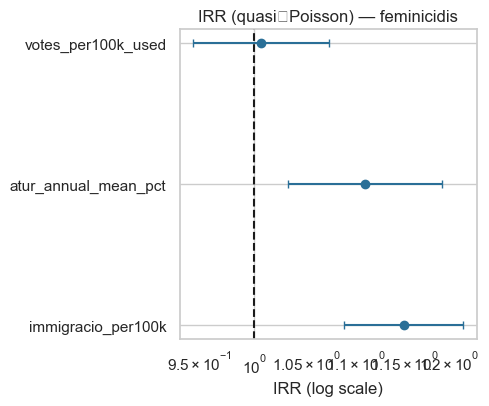

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("diagnostics_poisson_hc3_output_fixed_labels_quasipoisson/irr_quasi_poisson_feminicidis.csv")
# exclou la intercepció
df = df[df['term'] != 'const'].reset_index(drop=True)
x = df['irr_quasi']
xlo = df['irr_quasi_lo']
xhi = df['irr_quasi_hi']
ypos = range(len(df))[::-1]
plt.figure(figsize=(5,3+len(df)*0.4))
plt.errorbar(x, ypos, xerr=[x - xlo, xhi - x], fmt='o', color='#2A6F97', capsize=3)
plt.yticks(ypos, df['term'])
plt.xscale('log')
plt.axvline(1, color='k', linestyle='--')
plt.xlabel('IRR (log scale)')
plt.title("IRR (quasi‑Poisson) — feminicidis")
plt.tight_layout()
plt.savefig("forest_irr_feminicidis.png", dpi=300)
plt.show()

Candidates IRR cols: ['irr_quasi', 'irr_quasi_lo', 'irr_quasi_hi']


C:\Users\bfeli\AppData\Local\Temp\ipykernel_5988\3721890892.py:36: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  plt.tight_layout()
C:\Users\bfeli\AppData\Local\Temp\ipykernel_5988\3721890892.py:38: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  plt.savefig(out_png, dpi=300)
C:\Users\bfeli\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


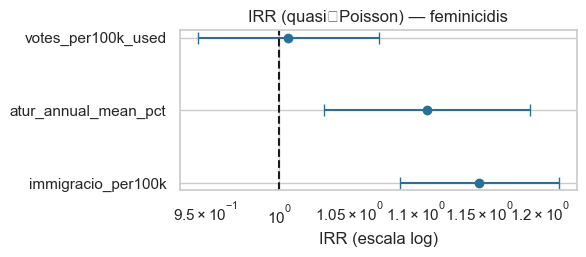

Guardat forest plot a: C:\Users\bfeli\forest_irr_feminicidis.png


In [31]:
import matplotlib.pyplot as plt
# Buscar la columna d'IRR i els límits
possible_irr_cols = [c for c in df.columns if "irr" in c.lower()]
print("Candidates IRR cols:", possible_irr_cols)

# 'irr_quasi', 'irr_quasi_lo', 'irr_quasi_hi'
irr_col = next((c for c in df.columns if 'irr_quasi' in c.lower()), None)
lo_col = next((c for c in df.columns if 'irr_quasi_lo' in c.lower()), None)
hi_col = next((c for c in df.columns if 'irr_quasi_hi' in c.lower()), None)

# Si no es troba, intentar noms alternatius
if irr_col is None:
    # fallback: look for 'irr' and 'irr_lo','irr_hi'
    irr_col = next((c for c in df.columns if c.lower() == 'irr'), None)
    lo_col = next((c for c in df.columns if 'irr_lo' in c.lower() or 'irr_low' in c.lower()), None)
    hi_col = next((c for c in df.columns if 'irr_hi' in c.lower() or 'irr_high' in c.lower()), None)

if irr_col is None or lo_col is None or hi_col is None:
    raise RuntimeError(f"No trobo columnes d'IRR/IC al CSV. Columnes disponibles: {df.columns.tolist()}")

# Excloure intercept
dfp = df[df['term'].str.lower() != 'const'].reset_index(drop=True)

x = dfp[irr_col].astype(float)
xlo = dfp[lo_col].astype(float)
xhi = dfp[hi_col].astype(float)
ypos = list(range(len(dfp)-1, -1, -1))

plt.figure(figsize=(6, 1.2 + len(dfp)*0.5))
plt.errorbar(x, ypos, xerr=[x - xlo, xhi - x], fmt='o', color='#2A6F97', capsize=4)
plt.yticks(ypos, dfp['term'])
plt.xscale('log')
plt.axvline(1, color='k', linestyle='--')
plt.xlabel('IRR (escala log)')
plt.title("IRR (quasi‑Poisson) — feminicidis")
plt.tight_layout()
out_png = r"C:\Users\bfeli\forest_irr_feminicidis.png"
plt.savefig(out_png, dpi=300)
plt.show()
print("Guardat forest plot a:", out_png)

In [32]:
diag_path = r"C:\Users\bfeli\diagnostics_poisson_hc3_output_fixed_labels_quasipoisson\diag_feminicidis.csv"
if os.path.exists(diag_path):
    diag = pd.read_csv(diag_path)
    top10 = diag.reindex(diag['pearson_pois'].abs().sort_values(ascending=False).index).head(10)
    out_top = r"C:\Users\bfeli\top_influencers_feminicidis.csv"
    top10[['orig_index','y','population','mu_pois','rate_obs','rate_pois','pearson_pois']].to_csv(out_top, index=False)
    print("Guardat top influencers a:", out_top)
else:
    print("No trobo diag_feminicidis.csv a la carpeta indicada:", diag_path)

Guardat top influencers a: C:\Users\bfeli\top_influencers_feminicidis.csv


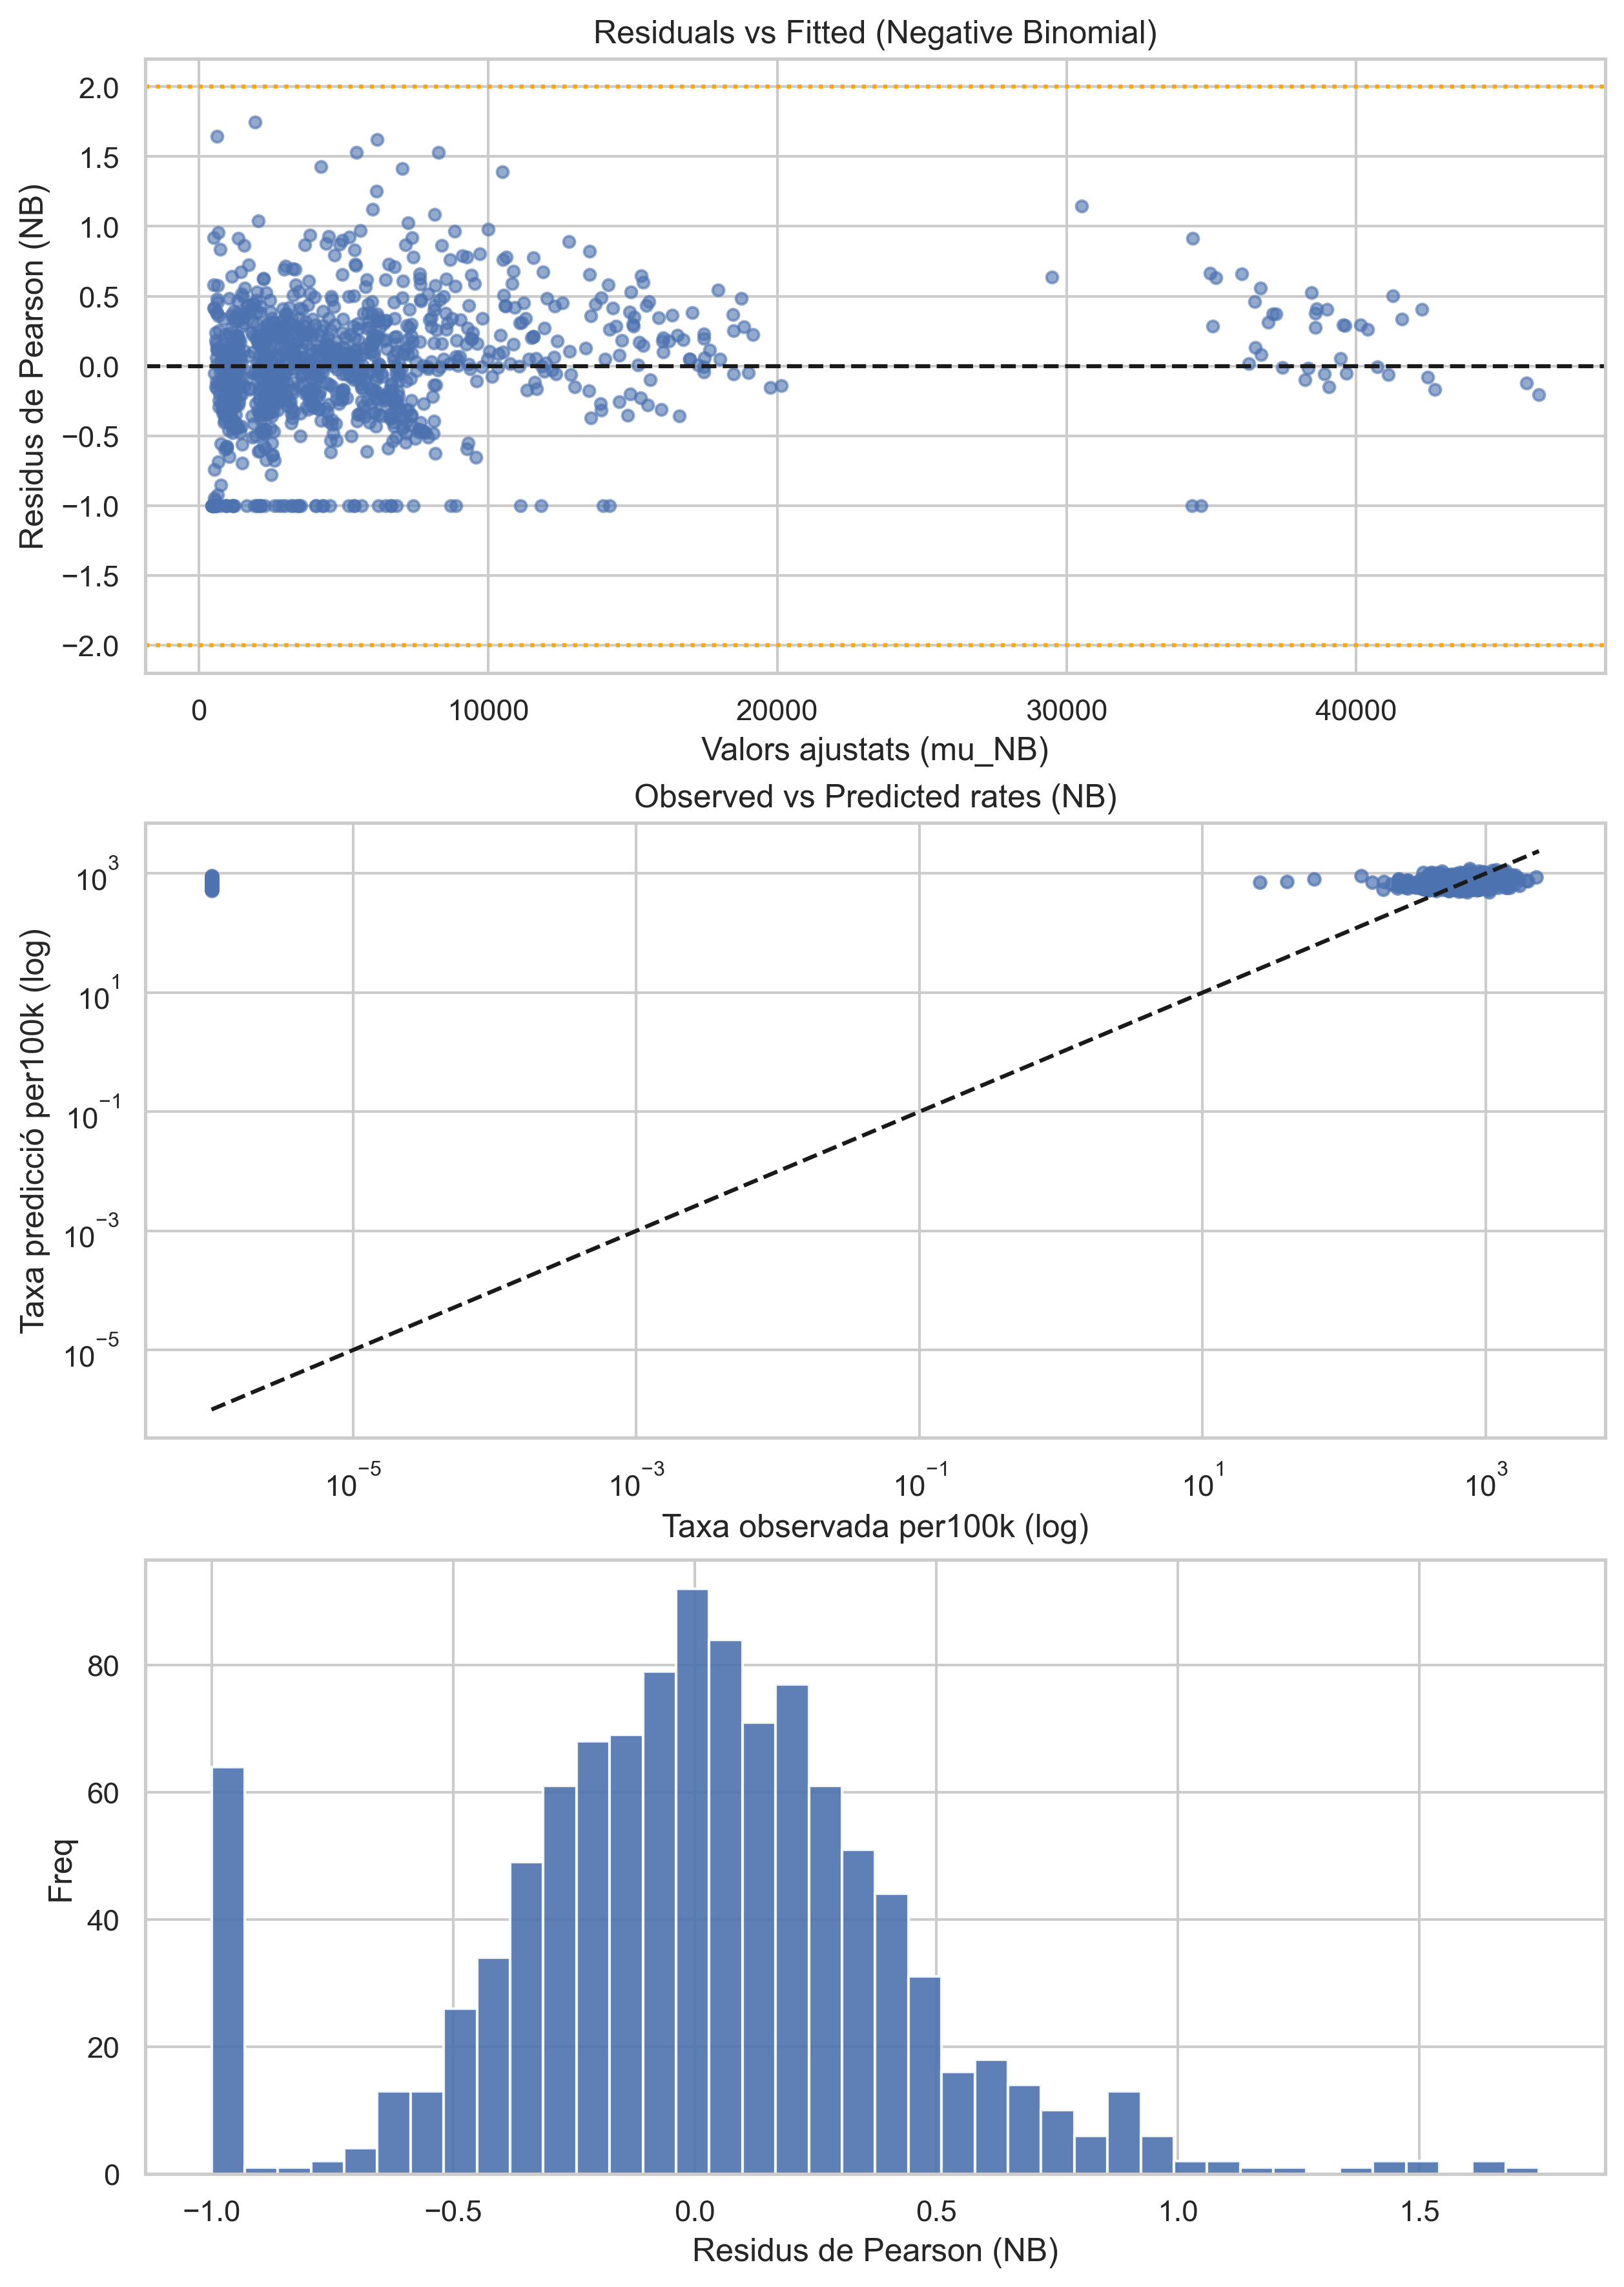

In [33]:
# Assumim que nb_res és l'objecte result de glm_nb.fit(...) per "denuncies"

import numpy as np
import matplotlib.pyplot as plt

# obtenir prediccions NB i residus (preferir nb_res.resid_pearson)
mu_nb = nb_res.predict(X, offset=offset)
try:
    pearson_nb = nb_res.resid_pearson
except Exception:
    # fallback: calcular amb alpha
    try:
        alpha = float(getattr(nb_res, "scale", np.nan))
    except Exception:
        alpha = alpha_moments(y, mu_nb) 
    var_nb = mu_nb + alpha * (mu_nb**2)
    pearson_nb = (y - mu_nb) / np.sqrt(np.maximum(var_nb, 1e-9))

# preparar rates per100k
rate_obs = (y / sub['population'].values) * 100000
rate_nb = (mu_nb / sub['population'].values) * 100000

# 3-panel plot
fig, axes = plt.subplots(3,1, figsize=(8.27,11.69), dpi=300, constrained_layout=True)

# 1) Residus vs fitted (pearson_nb)
ax = axes[0]
ax.scatter(mu_nb, pearson_nb, s=18, alpha=0.6)
ax.axhline(0, color='k', linestyle='--')
ax.axhline(2, color='orange', linestyle=':')
ax.axhline(-2, color='orange', linestyle=':')
ax.set_xlabel('Valors ajustats (mu_NB)')
ax.set_ylabel('Residus de Pearson (NB)')
ax.set_title('Residuals vs Fitted (Negative Binomial)')

# 2) Observed vs Predicted (log)
ax = axes[1]
eps = 1e-6
x = np.maximum(rate_obs, eps)
y_p = np.maximum(rate_nb, eps)
ax.scatter(x, y_p, s=20, alpha=0.7)
mx = max(np.nanmax(x), np.nanmax(y_p)) * 1.05
ax.plot([eps, mx], [eps, mx], linestyle='--', color='k')
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlabel('Taxa observada per100k (log)')
ax.set_ylabel('Taxa predicció per100k (log)')
ax.set_title('Observed vs Predicted rates (NB)')

# 3) Histograma residus
ax = axes[2]
ax.hist(pearson_nb, bins=40, color="#4C72B0", alpha=0.9)
ax.set_xlabel('Residus de Pearson (NB)')
ax.set_ylabel('Freq')

plt.show()